In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Z Limit tags are needed from LIMS. They have to be pulled through the web app
#### open http://lims2/focal_plane_image_series and search for 'Z-range limit' as an image series tag and then export to a csv

In [130]:
df = pd.read_csv('focal_plane_image_series.csv')
df['date_format'] = df['date'].apply(lambda x: pd.to_datetime(str(x),format = '%y%m%d'))

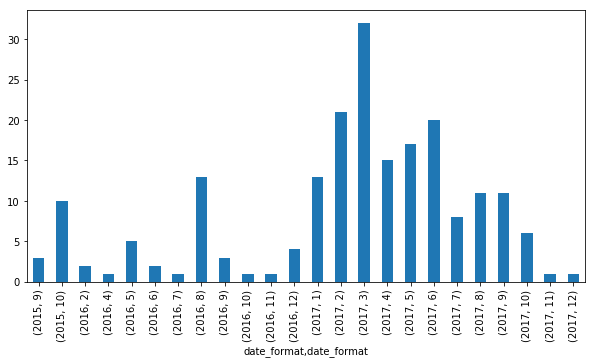

In [34]:
plt.figure(figsize = (10,5))
df['name'].groupby([df["date_format"].dt.year, df["date_format"].dt.month]).count().plot(kind="bar")

In [37]:
df.columns

Index([u'id', u'name', u'project', u'Unnamed: 3', u'donor', u'specimen',
       u'slides', u'workflow_state', u'display_tags', u'qc_date', u'runplan',
       u'date', u'date_format'],
      dtype='object')

# How does this compare to all the cells out there?

In [5]:
#sql code
import pg8000


def _connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    conn = pg8000.connect(user=user, host=host, database=database, password=password, port=port)
    return conn, conn.cursor()

def _select(cursor, query):
    cursor.execute(query)
    columns = [ d[0] for d in cursor.description ]
    return [ dict(zip(columns, c)) for c in cursor.fetchall() ]

def limsquery(query, user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    """A function that takes a string containing a SQL query, connects to the LIMS database and outputs the result."""
    conn, cursor = _connect(user, host, database, password, port)
    try:
        results = _select(cursor, query)
    finally:
        cursor.close()
        conn.close()
    return results


#this last function will take our query results and put them in a dataframe so that they are easy to work with
def get_lims_dataframe(query):
    '''Return a dataframe with lims query'''
    result = limsquery(query)
    try:
        data_df = pd.DataFrame(data=result, columns=result[0].keys())
    except IndexError:
        print "Could not find results for your query."
        data_df = pd.DataFrame()
    return data_df

In [181]:
query = "SELECT cell.name, cell.cell_depth, cell.created_at, donors.organism_id \
FROM specimens cell JOIN donors ON donors.id = cell.donor_id \
WHERE cell.ephys_roi_result_id IS NOT NULL \
AND cell.cell_depth IS NOT NULL"

query_df = get_lims_dataframe(query)
query_df.head()

,cell_depth,created_at,name,organism_id
0,53.1,2015-10-20 20:53:11.789708,H15.06.018.02.03.01,1
1,41.6,2015-10-20 21:37:55.903498,H15.06.018.02.03.02,1
2,67.8,2015-10-20 23:02:57.849617,H15.06.018.01.15.01,1
3,49.6,2016-01-25 18:57:44.882206,Vip-IRES-Cre;Ai14(IVSCC)-226109.05.01.01,2
4,60.0,2016-01-25 19:07:41.957818,Vip-IRES-Cre;Ai14(IVSCC)-226109.02.02.01,2


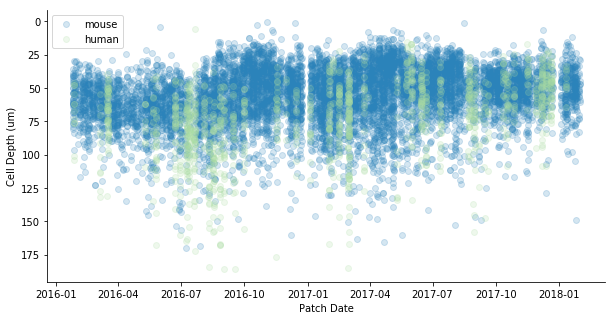

In [183]:
query_df = query_df[(query_df['cell_depth'] > 0) & (query_df['cell_depth'] <200) & 
                    (query_df['created_at'] > pd.Timestamp(2016, 1, 1))]

plt.figure(figsize = (10,5))

           
plt.plot_date(query_df[query_df['organism_id'] == 2].created_at, query_df[query_df['organism_id'] == 2].cell_depth, 
              alpha = .2, label = 'mouse', color = '#2b83ba')
plt.plot_date(query_df[query_df['organism_id'] == 1].created_at, query_df[query_df['organism_id'] == 1].cell_depth, 
              alpha = .2, label = 'human', color = '#abdda4')


plt.ylabel('Cell Depth (um)')
plt.xlabel('Patch Date')
sns.despine()
plt.legend()

#reverses the y axis so depth goes top to bottom
plt.gca().invert_yaxis()


# Join the 2 dataframes and plot the results

In [182]:
query_df = pd.merge(query_df, df, left_on = 'name', right_on = 'specimen', how = 'left')

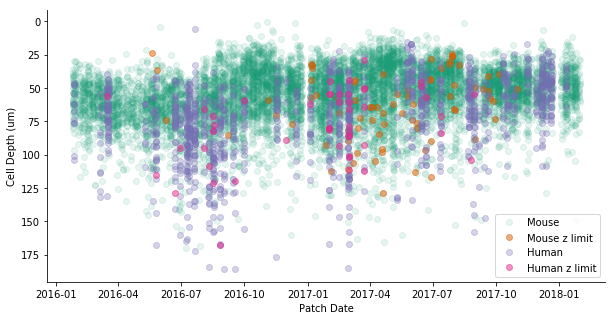

In [188]:
plt.figure(figsize = (10,5))

           
mouse_df = query_df[query_df['organism_id'] == 2]
plt.plot_date(mouse_df[mouse_df['display_tags'].isnull()].created_at, mouse_df[mouse_df['display_tags'].isnull()].cell_depth, 
              alpha = .1, label = 'Mouse', color = '#1b9e77')
plt.plot_date(mouse_df[mouse_df['display_tags'].notnull()].created_at, mouse_df[mouse_df['display_tags'].notnull()].cell_depth, 
              alpha = .5, label = 'Mouse z limit', color = '#d95f02')

human_df = query_df[query_df['organism_id'] == 1]
plt.plot_date(human_df[human_df['display_tags'].isnull()].created_at, human_df[human_df['display_tags'].isnull()].cell_depth, 
              alpha = .3, label = 'Human', color = '#7570b3')
plt.plot_date(human_df[human_df['display_tags'].notnull()].created_at, human_df[human_df['display_tags'].notnull()].cell_depth, 
              alpha = .5, label = 'Human z limit', color = '#e7298a')

plt.ylabel('Cell Depth (um)')
plt.xlabel('Patch Date')
sns.despine()
plt.legend()

#reverses the y axis so depth goes top to bottom
plt.gca().invert_yaxis()
